## Import the needed modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import rcParams
from sklearn.utils import resample

In [4]:
# import functions needed for the experiment
from utils.preprocess import preprocess_dataset
from utils.EDA import histogram, bivariate_analysis, get_correlation
# from utils.MLP_model import standardize_data, split_data, build_model_baseline, build_model_dropout, build_model_batch, compile_model_adam, compile_model_sdg, train_model, save_model, get_accuracy, plot_accuracy, predict, con_matrix, roc_curve_draw
from utils.MLP_model import *

## Import the dataset

In [5]:
client_data = pd.read_csv('Data/default_of_credit_card_clients.csv')
client_data.drop('ID', inplace=True, axis=1)
client_data.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [6]:
# rename the target column
client_data.rename(columns={"default payment next month": "target"}, inplace=True)
client_data.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


## Analyse and preprocess the data

In [7]:
# call the preprocess_dataset function
preproccessed_data = preprocess_dataset(client_data)

Info:
-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  

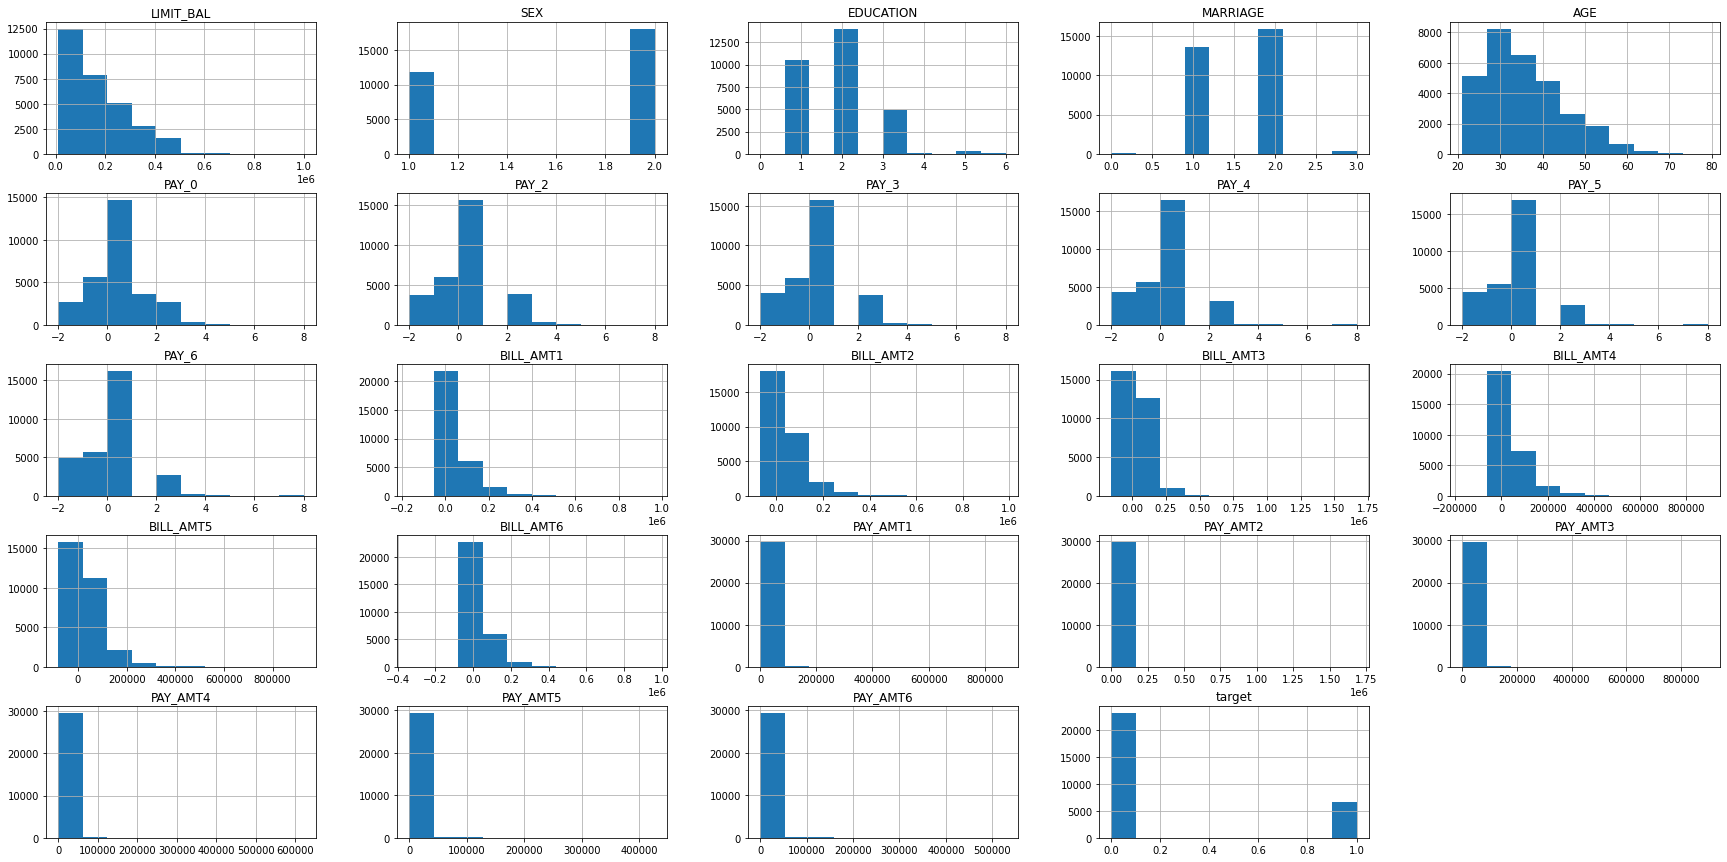

In [8]:
# graphical representation of each column in the dataset
histogram(preproccessed_data)

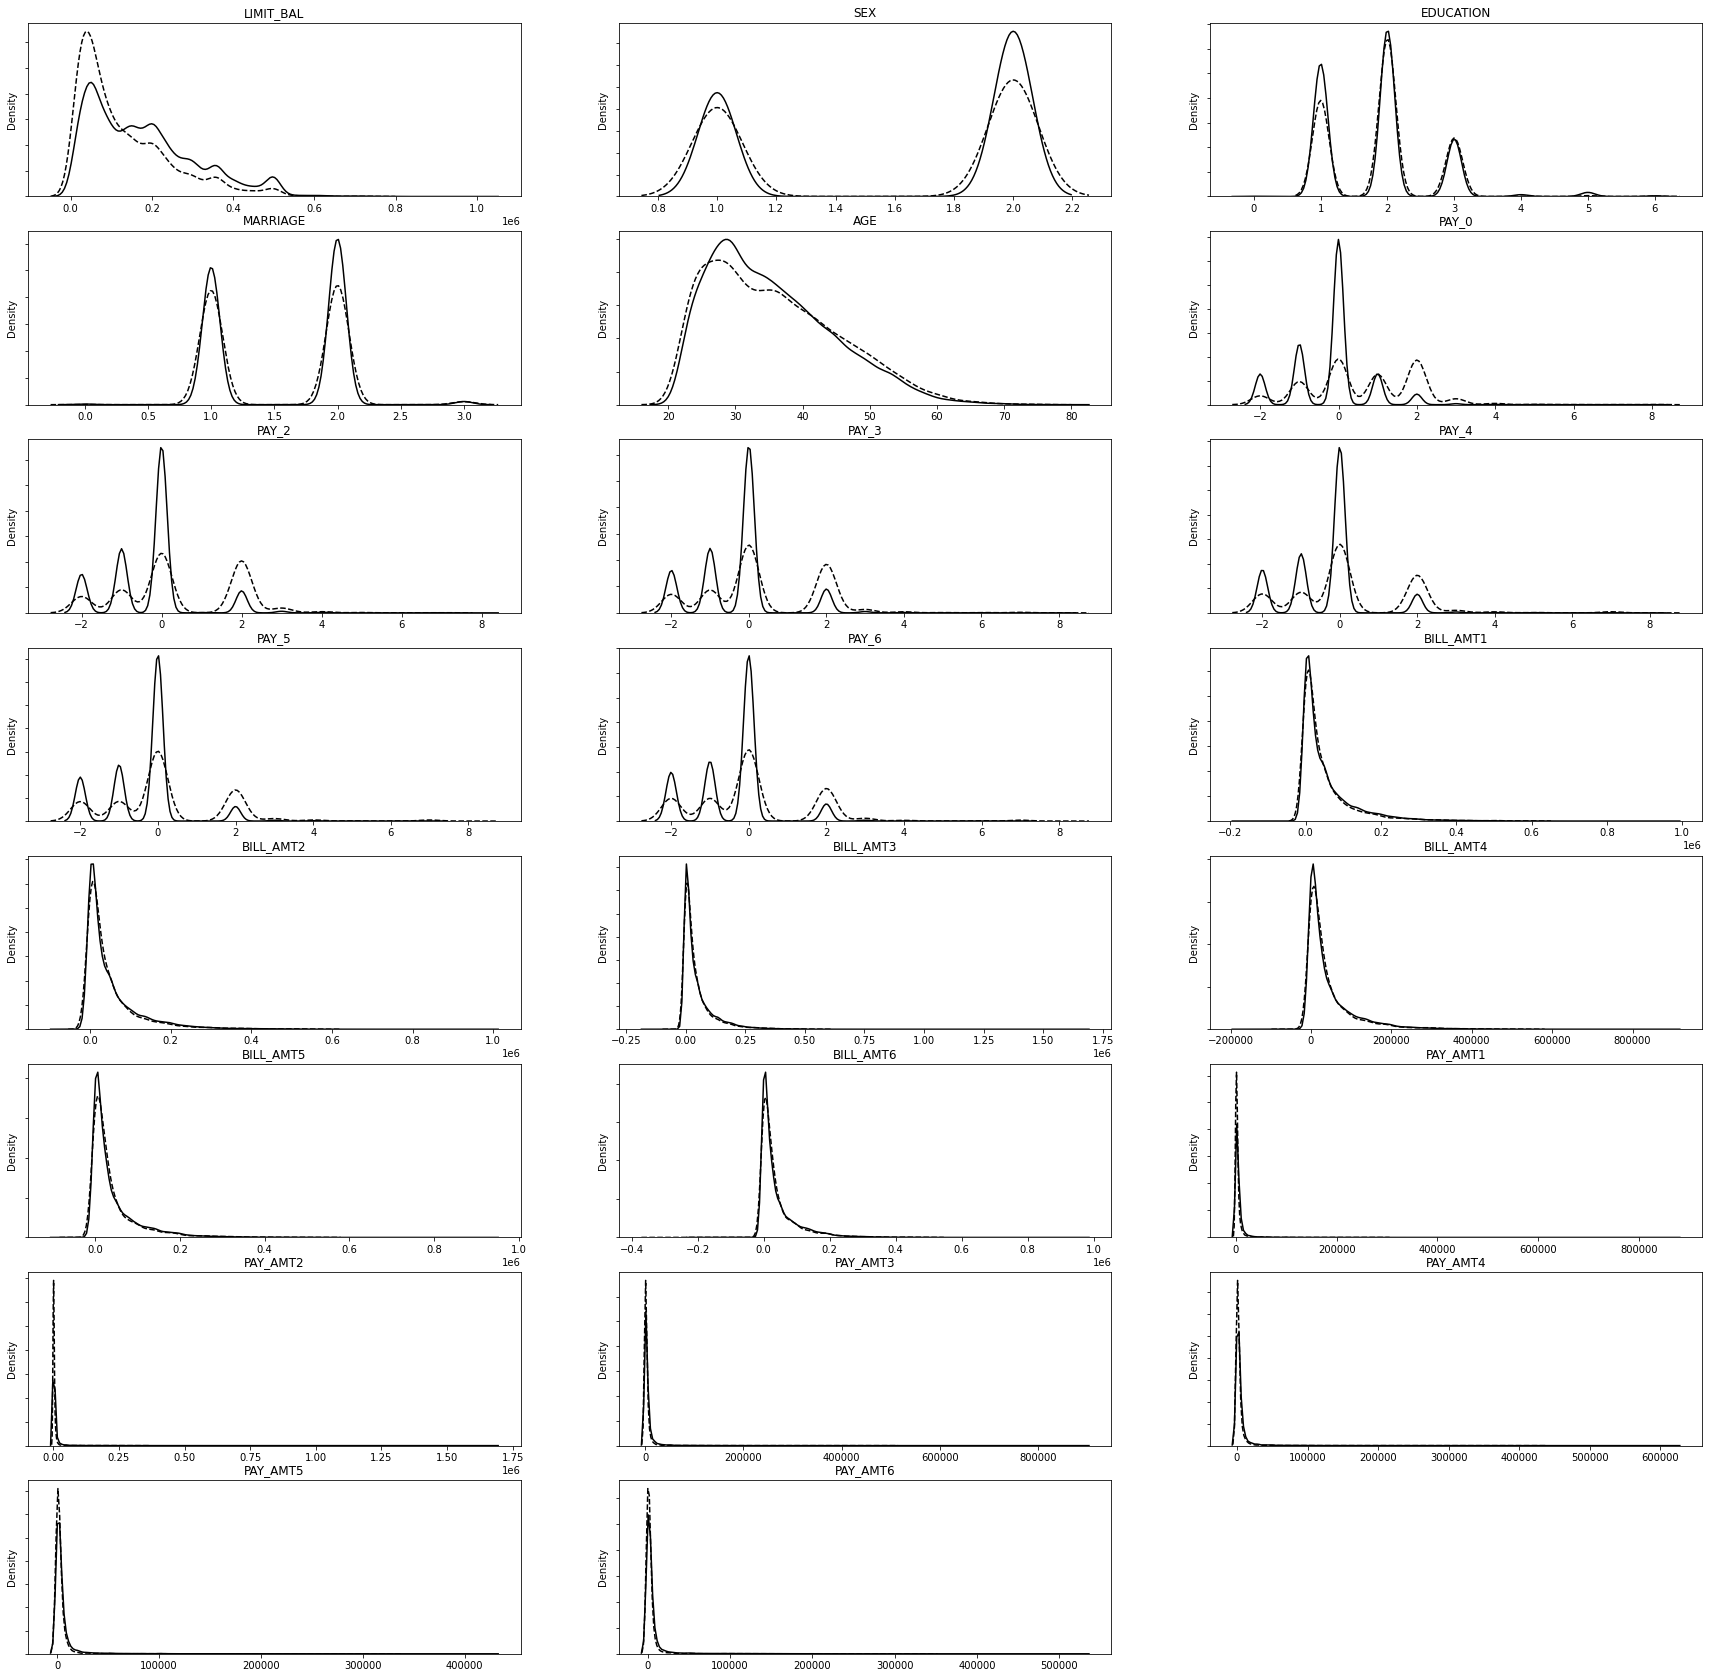

In [9]:
# call the bivariate_analysis function to visualize relationship of each column with the target column
bivariate_analysis(preproccessed_data)

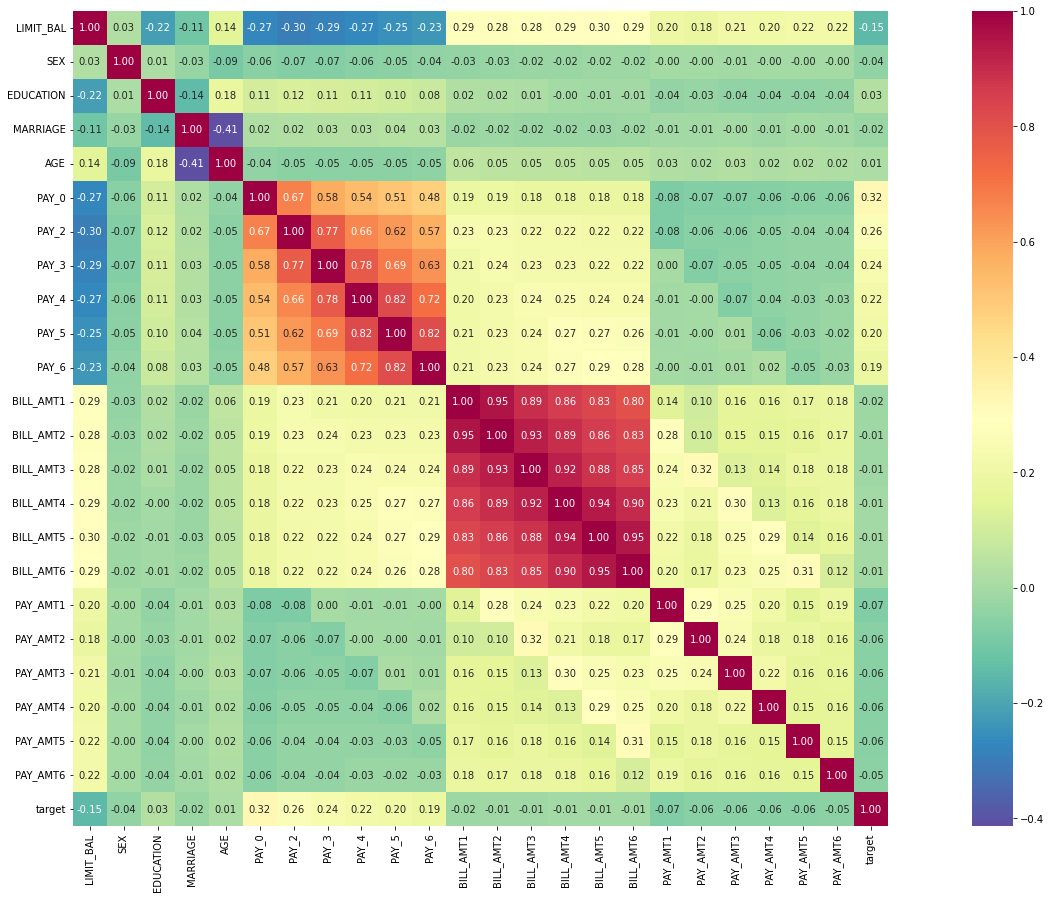

In [10]:
# show the correlation using heatmap
get_correlation(preproccessed_data)

## Preparing the data

1.  **Resample the data**

Based on the output from analysing our data, we can see a class imbalance in the target column, so we need to resample the data before building our model.

In [11]:
# dealing with class imbalance
def resample_data(data):
    # Separate majority and minority classes
    df_majority = data[data.target==0]
    df_minority = data[data.target==1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=23335,    # to match majority class
                                    random_state=42) 
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

In [12]:
# resample the data and view the result
resampled_data = resample_data(preproccessed_data)
resampled_data.target.value_counts()

0    23335
1    23335
Name: target, dtype: int64

In [13]:
resampled_data.shape

(46670, 24)

2. **Standardize the data**

In [14]:
x_features, target_variable = standardize_data(resampled_data)

Standardizing data...
---------------------


3. **Split the data into training and testing data**

We split the data into 80% train and 20% test. The training data is further splitted into 80% train data and 20% validation data when training the model.

In [15]:
x_train, x_test, y_train, y_test = split_data(x_features, target_variable)

Splitting dataset...
--------------------


In [16]:
# show the shape of our splitted data
print("Feature matrix:", x_train.shape)
print("Target matrix:", y_train.shape)
print("Feature matrix:", x_test.shape)
print("Target matrix:", y_test.shape)

Feature matrix: (37336, 23)
Target matrix: (37336,)
Feature matrix: (9334, 23)
Target matrix: (9334,)


## Build, compile, train, and evaluate the Multi-Layer Perceptron (MLP) model

* We make use of ***accuracy*** to evaluate the model. 
* We also show the ***confusion matrix*** and ***ROC curve***.
* We make use of ***adam***, ***sgd***, and ***adagrad*** as optimizers.
* We use ***binary_crossentropy*** as loss function.

1. **Build the MLP baseline model with dense layer.**

In [17]:
model = build_model_baseline()

Building model...
-----------------


In [18]:
# compile model with adam optimizer
compile_model_adam(model)

Compiling the model with adam optimizer...
------------------------------------------


In [19]:
# train the model 
history = train_model(model, x_train, y_train)

Training the model
------------------
Epoch 1/100
934/934 [==============================] - 6s 4ms/step - loss: 0.5999 - accuracy: 0.6890 - val_loss: 0.5782 - val_accuracy: 0.7001
Epoch 2/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5743 - accuracy: 0.7027 - val_loss: 0.5735 - val_accuracy: 0.7029
Epoch 3/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5674 - accuracy: 0.7082 - val_loss: 0.5681 - val_accuracy: 0.7055
Epoch 4/100
934/934 [==============================] - 2s 3ms/step - loss: 0.5626 - accuracy: 0.7104 - val_loss: 0.5662 - val_accuracy: 0.7047
Epoch 5/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5592 - accuracy: 0.7146 - val_loss: 0.5627 - val_accuracy: 0.7129
Epoch 6/100
934/934 [==============================] - 4s 4ms/step - loss: 0.5559 - accuracy: 0.7149 - val_loss: 0.5595 - val_accuracy: 0.7105
Epoch 7/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5542 - accuracy: 0.7173 - v

In [20]:
# save the model
save_model(model, "adam")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-28 23:54:16        33788
metadata.json                                  2023-02-28 23:54:16           64
config.json                                    2023-02-28 23:54:16         1923


In [21]:
# get model accuracy
get_accuracy(model, x_test, y_test, x_train, y_train)

Results:
--------
Training Accuracy: 73.72%

Training loss: 52.29%

Testing accuracy: 72.54%

Testing loss: 54.39%



In [22]:
# setting the figure parameters
rcParams['figure.figsize'] = (10, 5)

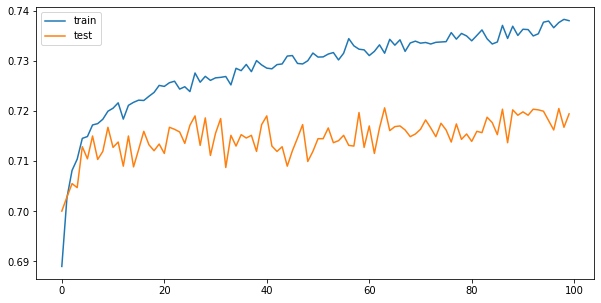

In [23]:
# plot the model accuracy
plot_accuracy(history, "adam")

In [24]:
# make predictions
y_pred = predict(model, x_test)

292/292 [==============================] - 1s 2ms/step


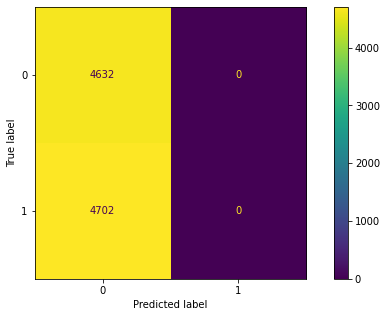

In [25]:
# plot the confusion matrix
con_matrix(y_test, y_pred, 'adam')

292/292 [==============================] - 1s 2ms/step


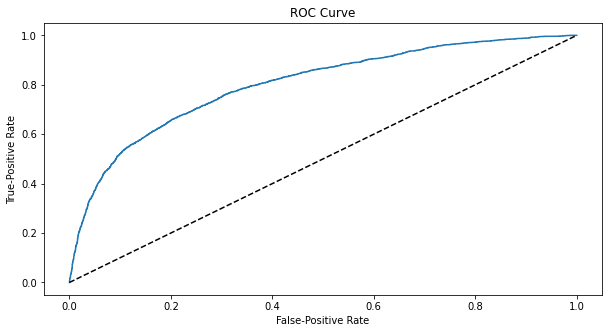

<Figure size 720x360 with 0 Axes>

In [26]:
# plot the roc curve
roc_curve_draw(model, x_test, y_test, 'adam')

2. **Changing the optimizer to SGD**

In [27]:
# build model
model_sdg = build_model_baseline()

Building model...
-----------------


In [28]:
# compile model using SDG optimizer
compile_model_sgd(model_sdg)

Compiling the model with SGD optimizer...
-----------------------------------------


In [29]:
# train the model
history_sdg = train_model(model_sdg, x_train, y_train)

Training the model
------------------
Epoch 1/100
934/934 [==============================] - 3s 3ms/step - loss: 0.6452 - accuracy: 0.6183 - val_loss: 0.5842 - val_accuracy: 0.6962
Epoch 2/100
934/934 [==============================] - 2s 3ms/step - loss: 0.5786 - accuracy: 0.7008 - val_loss: 0.5792 - val_accuracy: 0.6938
Epoch 3/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5716 - accuracy: 0.7042 - val_loss: 0.5714 - val_accuracy: 0.7013
Epoch 4/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5673 - accuracy: 0.7073 - val_loss: 0.5690 - val_accuracy: 0.6994
Epoch 5/100
934/934 [==============================] - 2s 2ms/step - loss: 0.5626 - accuracy: 0.7113 - val_loss: 0.5725 - val_accuracy: 0.6935
Epoch 6/100
934/934 [==============================] - 2s 2ms/step - loss: 0.5601 - accuracy: 0.7117 - val_loss: 0.5653 - val_accuracy: 0.7038
Epoch 7/100
934/934 [==============================] - 2s 3ms/step - loss: 0.5586 - accuracy: 0.7105 - v

In [30]:
# save the model
save_model(model_sdg, "sgd")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 00:00:31        21100
metadata.json                                  2023-03-01 00:00:31           64
config.json                                    2023-03-01 00:00:31         2137


In [31]:
# print the model accuracy
get_accuracy(model_sdg, x_test, y_test, x_train, y_train)

Results:
--------
Training Accuracy: 73.81%

Training loss: 52.03%

Testing accuracy: 72.35%

Testing loss: 55.16%



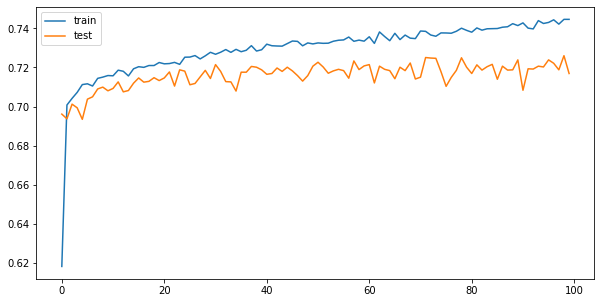

In [32]:
# plot the accuracy
plot_accuracy(history_sdg, "with_sgd")

In [33]:
# make predictions
y_pred_sdg = predict(model_sdg, x_test)

292/292 [==============================] - 1s 2ms/step


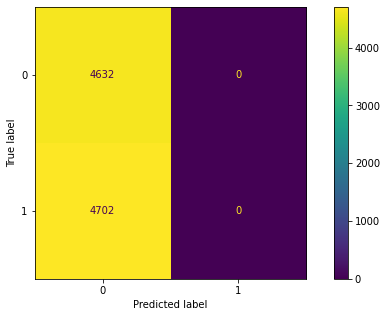

In [34]:
# plot the confusion matrix
con_matrix(y_test, y_pred_sdg, "with_sgd")

292/292 [==============================] - 1s 2ms/step


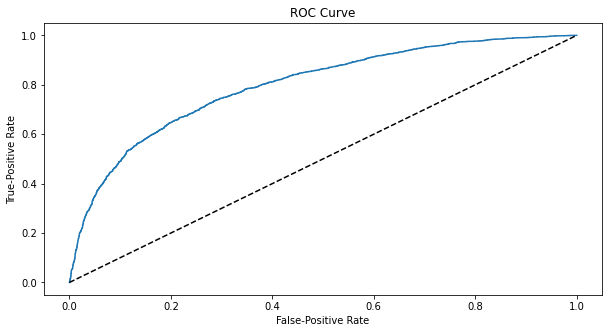

<Figure size 720x360 with 0 Axes>

In [35]:
# plot the roc curve
roc_curve_draw(model_sdg, x_test, y_test, "with_sgd")

3. **Changing the optimizer to Adagrad**

In [36]:
# compile model with adagrad optimizer
compile_model_adagrad(model)

Compiling the model with AdaGrad optimizer...
---------------------------------------------


In [37]:
# train the model 
history_ada = train_model(model, x_train, y_train)

Training the model
------------------
Epoch 1/100
934/934 [==============================] - 4s 3ms/step - loss: 0.5136 - accuracy: 0.7410 - val_loss: 0.5463 - val_accuracy: 0.7187
Epoch 2/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5126 - accuracy: 0.7420 - val_loss: 0.5462 - val_accuracy: 0.7185
Epoch 3/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5123 - accuracy: 0.7421 - val_loss: 0.5462 - val_accuracy: 0.7185
Epoch 4/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5121 - accuracy: 0.7425 - val_loss: 0.5462 - val_accuracy: 0.7192
Epoch 5/100
934/934 [==============================] - 3s 4ms/step - loss: 0.5120 - accuracy: 0.7430 - val_loss: 0.5462 - val_accuracy: 0.7181
Epoch 6/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5119 - accuracy: 0.7426 - val_loss: 0.5462 - val_accuracy: 0.7199
Epoch 7/100
934/934 [==============================] - 2s 3ms/step - loss: 0.5119 - accuracy: 0.7429 - v

In [38]:
# save the model
save_model(model, "adagrad")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 00:10:53        28976
metadata.json                                  2023-03-01 00:10:53           64
config.json                                    2023-03-01 00:10:53         1926


In [39]:
# get model accuracy
get_accuracy(model, x_test, y_test, x_train, y_train)

Results:
--------
Training Accuracy: 73.85%

Training loss: 51.82%

Testing accuracy: 72.59%

Testing loss: 54.16%



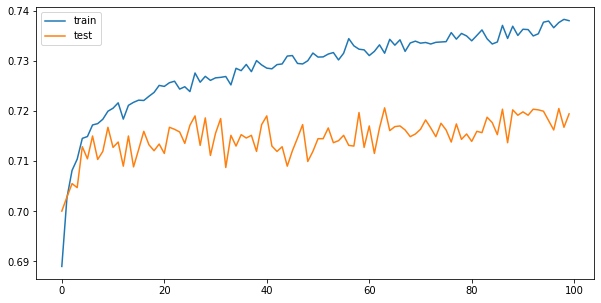

In [40]:
# plot the model accuracy
plot_accuracy(history, "adagrad")

In [41]:
# make predictions
y_pred = predict(model, x_test)

292/292 [==============================] - 1s 2ms/step


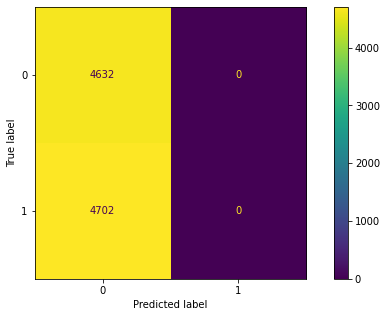

In [42]:
# plot the confusion matrix
con_matrix(y_test, y_pred, 'adagrad')

292/292 [==============================] - 1s 2ms/step


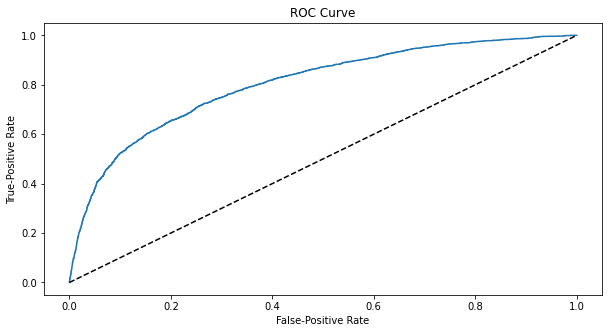

<Figure size 720x360 with 0 Axes>

In [43]:
# plot the roc curve
roc_curve_draw(model, x_test, y_test, 'adagrad')

4. **Applying dropout to the model to reduce overfitting**

In [44]:
# build the model
model_drop = build_model_dropout()

Building model with dropout...
------------------------------


In [46]:
# compile the model
compile_model_sgd(model_drop)

Compiling the model with SGD optimizer...
-----------------------------------------


In [47]:
# train the model
history_drop = train_model(model_drop, x_train, y_train)

Training the model
------------------
Epoch 1/100
934/934 [==============================] - 4s 3ms/step - loss: 0.6573 - accuracy: 0.6002 - val_loss: 0.5903 - val_accuracy: 0.6887
Epoch 2/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5923 - accuracy: 0.6921 - val_loss: 0.5787 - val_accuracy: 0.7005
Epoch 3/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5830 - accuracy: 0.6996 - val_loss: 0.5728 - val_accuracy: 0.7033
Epoch 4/100
934/934 [==============================] - 3s 4ms/step - loss: 0.5785 - accuracy: 0.7032 - val_loss: 0.5695 - val_accuracy: 0.7038
Epoch 5/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5751 - accuracy: 0.7046 - val_loss: 0.5688 - val_accuracy: 0.7029
Epoch 6/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5746 - accuracy: 0.7064 - val_loss: 0.5692 - val_accuracy: 0.6951
Epoch 7/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5718 - accuracy: 0.7075 - v

In [48]:
# save the model
save_model(model_drop, "with_dropout")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 00:18:07        26688
metadata.json                                  2023-03-01 00:18:07           64
config.json                                    2023-03-01 00:18:07         2549


In [49]:
# get the accuracy
get_accuracy(model_drop, x_test, y_test, x_train, y_train)

Results:
--------
Training Accuracy: 72.63%

Training loss: 53.65%

Testing accuracy: 72.28%

Testing loss: 54.45%



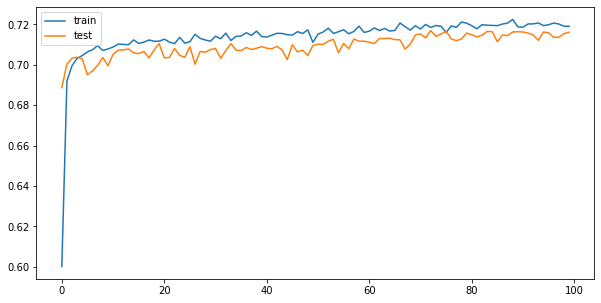

In [50]:
# plot the accuracy
plot_accuracy(history_drop, "with_dropout")

In [51]:
# make predictions
y_pred_drop = predict(model_drop, x_test)

292/292 [==============================] - 1s 2ms/step


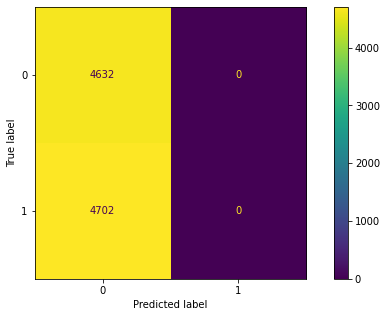

In [52]:
# plot confusion matrix
con_matrix(y_test, y_pred_drop, "with_dropout")

292/292 [==============================] - 1s 2ms/step


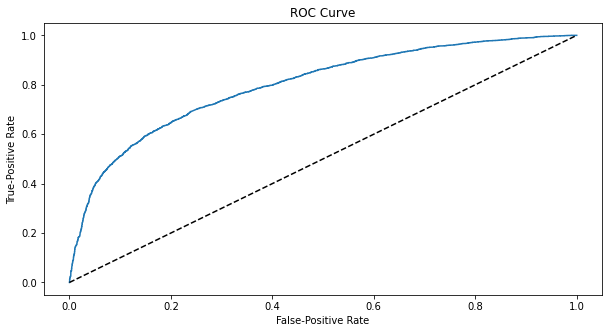

<Figure size 720x360 with 0 Axes>

In [53]:
# plot roc curve
roc_curve_draw(model_drop, x_test, y_test, "with_dropout")

5. **Introducing batch normalization**

In [54]:
# build the model
model_batch = build_model_batch()

Building model with batch normalization...
------------------------------------------


In [56]:
# compile the model
compile_model_sgd(model_batch)

Compiling the model with SGD optimizer...
-----------------------------------------


In [57]:
# train the model
history_batch = train_model(model_batch, x_train, y_train)

Training the model
------------------
Epoch 1/100
934/934 [==============================] - 5s 3ms/step - loss: 0.5966 - accuracy: 0.6847 - val_loss: 0.5795 - val_accuracy: 0.6901
Epoch 2/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5858 - accuracy: 0.6936 - val_loss: 0.5761 - val_accuracy: 0.6972
Epoch 3/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5786 - accuracy: 0.6955 - val_loss: 0.5707 - val_accuracy: 0.6984
Epoch 4/100
934/934 [==============================] - 4s 4ms/step - loss: 0.5760 - accuracy: 0.7010 - val_loss: 0.5678 - val_accuracy: 0.7084
Epoch 5/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5771 - accuracy: 0.6994 - val_loss: 0.5685 - val_accuracy: 0.7041
Epoch 6/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5751 - accuracy: 0.6991 - val_loss: 0.5643 - val_accuracy: 0.7065
Epoch 7/100
934/934 [==============================] - 3s 3ms/step - loss: 0.5740 - accuracy: 0.7026 - v

In [58]:
# save the model
save_model(model_batch, "with_batch_normalization")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 00:25:42        33088
metadata.json                                  2023-03-01 00:25:42           64
config.json                                    2023-03-01 00:25:42         3669


In [59]:
# get the accuracy
get_accuracy(model_batch, x_test, y_test, x_train, y_train)

Results:
--------
Training Accuracy: 72.62%

Training loss: 54.22%

Testing accuracy: 72.50%

Testing loss: 54.65%



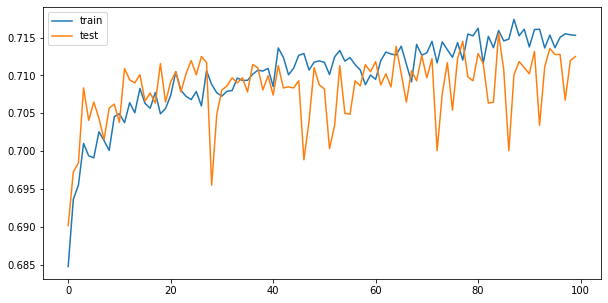

In [60]:
# plot the accuracy
plot_accuracy(history_batch, "with_batch_normalization")

In [61]:
# make predictions
y_pred_batch = predict(model_batch, x_test)

292/292 [==============================] - 1s 2ms/step


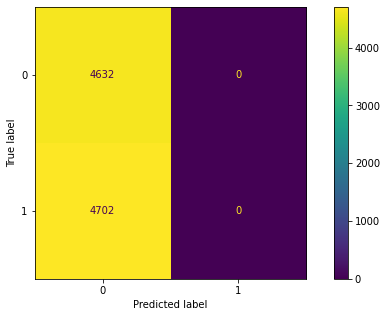

In [62]:
# plot confusion matrix
con_matrix(y_test, y_pred_batch, "with_batch_normalization")

292/292 [==============================] - 1s 3ms/step


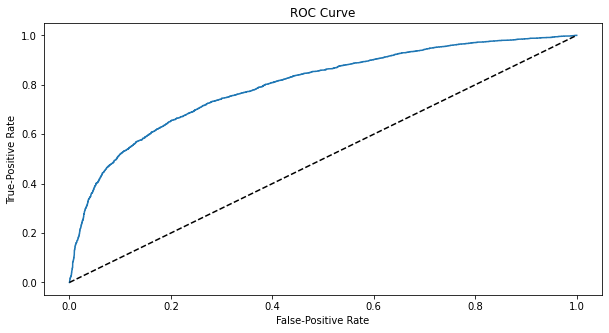

<Figure size 720x360 with 0 Axes>

In [63]:
# plot roc curve
roc_curve_draw(model_batch, x_test, y_test, "with_batch_normalization")

## Comparing the results

In [64]:
# manually create accuracy dataframe
# accuracy_data = [[71.44, 71.35, 'Adam'], [74.28, 72.97, 'SGD'], [72.36, 72.17, 'SGD(dropout)'], [71.92, 71.22, 'SGD(dropout_and_batch_normalization']]
accuracy_data = [[73.81, 72.35, 'SGD'], [72.63, 72.28, 'SGD(dropout)'], [72.62, 72.50, 'SGD(dropout_and_batch_normalization']]
accuracy_df = pd.DataFrame(data=accuracy_data, columns=["Train", "Test", "Hyperparameters"])
accuracy_df

,Train,Test,Hyperparameters
0,73.81,72.35,SGD
1,72.63,72.28,SGD(dropout)
2,72.62,72.50,SGD(dropout_and_batch_normalization


In [65]:
# define function to plot accuracy for all hyperparameters
def plot_accuracy_all(data, x, y, alias_):
    ax = sns.barplot(data=data, x=x, y=y)
    # sns.barplot(data=accuracy_df, x="Hyperparameters", y="Test")
    for i in ax.containers:
        ax.bar_label(i,)
    plt.savefig(f'accuracy_{alias_}.png')
    plt.show()

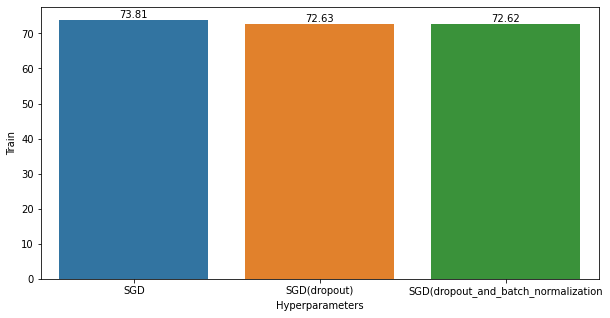

In [66]:
# plot for train accuracy
plot_accuracy_all(accuracy_df, accuracy_df.Hyperparameters, accuracy_df.Train, "train")

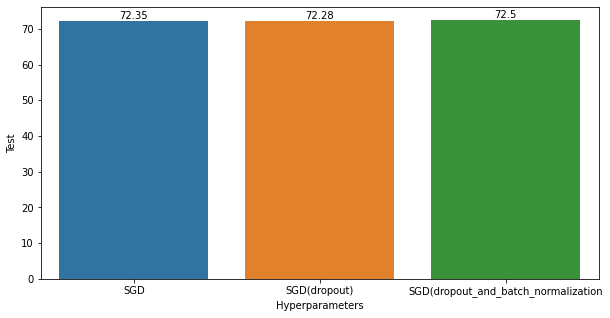

In [67]:
# plot for test accuracy
plot_accuracy_all(accuracy_df, accuracy_df.Hyperparameters, accuracy_df.Test, "test")